## SMSecure 

SMSecure è un progetto che ha come obiettivo quello di realizzare un filtro anti spam. Quindi a partire da un semplice dataset andrò ad effettuare le operazioni necessarie per trovare relazioni tra i dati, preprocessare i dati, e infine utilizzare i dati per addestrare un modello di ML.

In [249]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

leggo il dataset e stampo un campione (prime 5 righe)

In [250]:
df = pd.read_csv('sms_dataset.csv', encoding="ISO-8859-1")
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5427,spam,Santa Calling! Would your little ones like a c...,NaN,NaN,NaN
977,ham,Dont hesitate. You know this is the second tim...,NaN,NaN,NaN
5363,ham,"I think your mentor is , but not 100 percent s...",NaN,NaN,NaN
4891,ham,Miserable. They don't tell u that the side eff...,NaN,NaN,NaN
3141,ham,Not planned yet :)going to join company on jan...,NaN,NaN,NaN


numero righe e colonne del dataset

In [251]:
df.shape

(5572, 5)

## Data Cleaning

stampo le info del dataset per fare una panoramica

In [252]:
df.info

<bound method DataFrame.info of         v1                                                 v2 Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3      ham  U dun say so early hor... U c already then say...        NaN   
4      ham  Nah I don't think he goes to usf, he lives aro...        NaN   
...    ...                                                ...        ...   
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham              Will Ì_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...any other s...        NaN   
5570   ham  The guy did some bitching but I acted like i'd...        NaN   
5571   ham                         Rofl. Its true to its name        NaN   

     Unnamed: 3 Unnamed: 4  
0           NaN        NaN

si può notare che ci sono delle colonne inutili (ultime 3), quindi vanno eliminate

In [253]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
df.sample(5)

,v1,v2
986,ham,I'm in office now . I will call you &lt;#&gt;...
3588,ham,I've sent my wife your text. After we buy them...
3268,ham,Raviyog Peripherals bhayandar east
3140,ham,Customer place i will call you
1698,spam,"Free msg. Sorry, a service you ordered from 81..."


rinomino le colonne v1 e v2 con nomi migliori

In [254]:
df.rename(columns={'v1':'target', 'v2':'text'}, inplace=True)
df.sample(5)

,target,text
3901,ham,"Right on brah, see you later"
1275,ham,Wot u up 2 u weirdo?
3443,ham,Yes but I don't care cause I know its there!
2508,ham,Ok...
4564,ham,Honeybee Said: *I'm d Sweetest in d World* God...


ora devo traformare il target "ham/spam" in codifica binaria 0/1 quindi ho bisogno di sickitLearn e più nello specifico di LabelEncoder che viene utilizzato per convertire etichette categoriche in numeri interi in modo che possano essere utilizzate come input per algoritmi di machine learning. 


In [255]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [256]:
df['target'] = encoder.fit_transform(df['target'])
df.sample(5)

,target,text
2071,0,Good night my dear.. Sleepwell&amp;Take care
1226,1,Reply with your name and address and YOU WILL ...
1307,1,"Get 3 Lions England tone, reply lionm 4 mono o..."
3920,0,Do 1 thing! Change that sentence into: \Becaus...
4616,0,Good. do you think you could send me some pix?...


quindi ora gli spam saranno indicati come 1, gli ham come 0

controllo se sono presenti valori nulli o duplicati, e nel caso risolvo

In [257]:
df.isnull().sum()

target    0
text      0
dtype: int64

non ci sono valori nulli, procedo a verificare eventuali duplicati

In [258]:
df.duplicated().sum()

403

procedo a rimuovere i 403 duplicati

In [259]:
df = df.drop_duplicates(keep='first')

In [260]:
df.duplicated().sum()

0

ho risolto! Ora il dataset ha 0 nulli e 0 duplicati

# Analisi dei dati

fase in cui si esplorano, visualizzano e comprendono i dati per scoprire informazioni rilevanti, tendenze, relazioni e anomalie nei dati.

In [261]:
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

Quindi il mio dataset ha 4516 SMS "ham" e 653 "spam"

vado a rappresentare tale informazione usando un grafico a torta

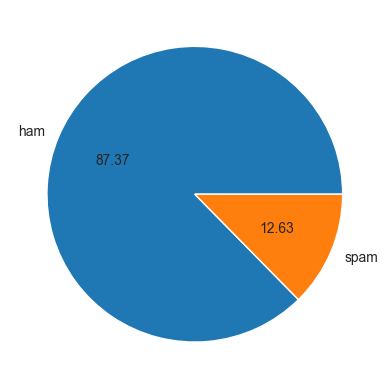

In [262]:
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct="%0.2f")
plt.show()

Quindi da tale grafico si può notare che i dati non sono bilanciati

# Data Preparation (Data Balancing )

provo a bilanciare i dati, andando a fare un clustering. Dopo aver eseguito il clustering, ed avere individuato i migliori clustering, ovvero quelli più rappresentativi grazie silhouette, vado a selezionare un pò di dati da questi cluster.
L'indice silhouette è una misura usata per valutare la qualità della clusterizzazione dei dati in un problema di clustering. È spesso utilizzato per valutare quanto bene i dati sono stati assegnati ai cluster. 

Il punteggio silhouette varia da -1 a 1, dove:

- Valori vicini a 1 indicano che il campione è stato assegnato correttamente al cluster.
- Valori vicini a 0 indicano che il campione è vicino ai confini tra due cluster.
- Valori vicini a -1 indicano che il campione è stato assegnato erroneamente al cluster sbagliato.
- In generale, un valore silhouette più alto è indicativo di una migliore clusterizzazione. 

In [263]:
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.metrics import silhouette_samples, silhouette_score

# Divido il dataframe in due parti separate ham/spam
ham = df[df['target'] == 0]
spam = df[df['target'] == 1]

# Eseguo il clustering dei campioni "ham" con K-Means (ML non supervisionato)
num_clusters = 2 # ho scelto un numero di cluster in base ai valori medi della silhouette
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
ham['cluster'] = kmeans.fit_predict(ham['text'].str.len().values.reshape(-1, 1))

# Calcolo il valore della Silhouette per ciascun campione
sample_silhouette_values = silhouette_samples(ham['text'].str.len().values.reshape(-1, 1), ham['cluster'])

# Calcola la Silhouette Score media per tutti i campioni nella classe "ham"
silhouette_avg = silhouette_score(ham['text'].str.len().values.reshape(-1, 1), ham['cluster'])

# Trovo i cluster con Silhouette Score più alti
best_clusters = []
for cluster_id in range(num_clusters):
    cluster_silhouette_values = sample_silhouette_values[ham['cluster'] == cluster_id]
    avg_silhouette = np.mean(cluster_silhouette_values)
    best_clusters.append((cluster_id, avg_silhouette))

for cluster_id, avg_silhouette in best_clusters:   #stampa usata per vedere i valori della silhouette
    print(f"Cluster {cluster_id}: Silhouette Score medio = {avg_silhouette}")

# Ordino i cluster in base alla Silhouette Score in ordine decrescente
best_clusters = sorted(best_clusters, key=lambda x: x[1], reverse=True)

# Scelgo i primi 2 cluster (i migliori) come cluster rappresentativi
representative_clusters = [cluster[0] for cluster in best_clusters[:2]] 

# Eseguo l'undersampling dai cluster rappresentativi, ovvero prendo solo un tot di righe da essi.

undersampled_ham = pd.DataFrame() #creo un nuovo dataframe

num_samples_per_cluster = 320  # Numero di campioni da campionare da ciascun cluster rappresentativo

#vado a selezionare 320 campioni dai due cluster migliori, e li inserisco nel dataframe undersampled_ham.
for cluster_id in representative_clusters:
    cluster_samples = ham[ham['cluster'] == cluster_id]
    # Eseguo l'undersampling (campiona da ciascun cluster rappresentativo)
    cluster_samples = resample(cluster_samples, replace=False, n_samples=num_samples_per_cluster, random_state=42)
    # Aggiungo i campioni campionati all'insieme di campioni sottocampionati
    undersampled_ham = pd.concat([undersampled_ham, cluster_samples])

# Combina l'undersampled classe "ham" con il dataframe che contiene la classe "spam" per ottenere il dataset bilanciato
df_undersampled = pd.concat([undersampled_ham, spam])

# Ora df_undersampled contiene il dataset bilanciato, quindi copio in variabile df, ovvero il df che uso di default.

df = df_undersampled


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/zq/qftd43l52j55ztwn7drwlhl40000gn/T/ipykernel_10493/1625856083.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ham['cluster'] = kmeans.fit_predict(ham['text'].str.len().values.reshape(-1, 1))


Cluster 0: Silhouette Score medio = 0.5025812842854496
Cluster 1: Silhouette Score medio = 0.7404661949423422


Basandomi sui punteggi della Silhouette Score media:

- 2 cluster: Cluster 0 con Silhouette Score medio 0.716 e Cluster 1 con Silhouette Score medio 0.564.
- 3 cluster: Cluster 0 con Silhouette Score medio 0.716, Cluster 1 con Silhouette Score medio 0.564, e Cluster 2 con Silhouette Score medio 0.414.
- 5 cluster: il Cluster 0 con 0.50, Cluster 1 con 0.49, Cluster 2 con 0.55, Cluster 3 con 0.50, Cluster 4 con 0.65

Tra le opzioni di 2 cluster, 3 cluster e 5 cluster, mi è sembrato opportuno fare una suddivisione in 2 cluster, difatti il silouhette score medio è più alto.

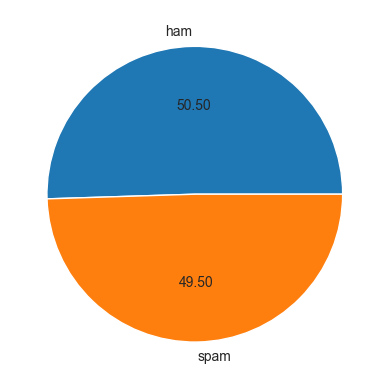

In [264]:
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct="%0.2f")
plt.show()

In [265]:
df['target'].value_counts()

target
1    653
0    640
Name: count, dtype: int64

ora posso andare copiare tutto su df, eliminando la colonna cluster dato che non mi servirà più

In [266]:
df = df_undersampled.drop(columns=['cluster'])
df.sample(5)

,target,text
723,0,Ya even those cookies have jelly on them
5378,1,Free entry to the gr8prizes wkly comp 4 a chan...
3686,0,Great! I shoot big loads so get ready!
1375,0,We're finally ready fyi
3527,1,You are a å£1000 winner or Guaranteed Caller P...


In [267]:
#ho dovuto fare tutto ciò perchè non riuscivo a effettuare il download di nltk
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/samuelerusso/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Ho scaricato la libreria Nltk Python ampiamente utilizzata per il trattamento del linguaggio naturale. Tra gli strumenti presenti, c'è il tokenizer NLTK denominato "Punkt" che viene utilizzato per la suddivisione di testo in frasi ed è molto utile quando si desidera suddividere un testo in frasi al fine di analizzarle o elaborarle in modo più dettagliato.

ora vado a vedere la lungehzza in caratteri di ogni messaggio 

In [268]:
df['text'].apply(len) 


1147     45
437      36
2283     33
5514     33
3443     44
       ... 
5537     90
5540    160
5547    160
5566    147
5567    161
Name: text, Length: 1293, dtype: int64

quindi creo una nuova colonna nel dataset in cui indico il numero di caratteri e stampo un sample per vedere che tutto ha funzionato

In [269]:
df['num_characters'] = df['text'].apply(len)
df.head()

,target,text,num_characters
1147,0,Ok... Help me ask if she's working tmr a not?,45
437,0,How long does applebees fucking take,36
2283,0,I reach home safe n sound liao...,33
5514,0,Oh... Okie lor...We go on sat...,33
3443,0,Yes but I don't care cause I know its there!,44


vado ora a calcolare il numero di parole in ogni messaggio, utilizzando il tokenizer della libreria nltk. Vado anche qui a creare una colonna.

In [270]:
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df.head()

,target,text,num_characters,num_words
1147,0,Ok... Help me ask if she's working tmr a not?,45,13
437,0,How long does applebees fucking take,36,6
2283,0,I reach home safe n sound liao...,33,8
5514,0,Oh... Okie lor...We go on sat...,33,10
3443,0,Yes but I don't care cause I know its there!,44,12


vado ora a calcolare il numero di frasi per ogni messaggio e metto i dati in una nuova colonna

In [271]:
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

,target,text,num_characters,num_words,num_sentences
1147,0,Ok... Help me ask if she's working tmr a not?,45,13,1
437,0,How long does applebees fucking take,36,6,1
2283,0,I reach home safe n sound liao...,33,8,1
5514,0,Oh... Okie lor...We go on sat...,33,10,1
3443,0,Yes but I don't care cause I know its there!,44,12,1


stampo un grafico che mi faccia vedere le differenze di caratteri tra sms ham/spam.

<Axes: xlabel='num_characters', ylabel='Count'>

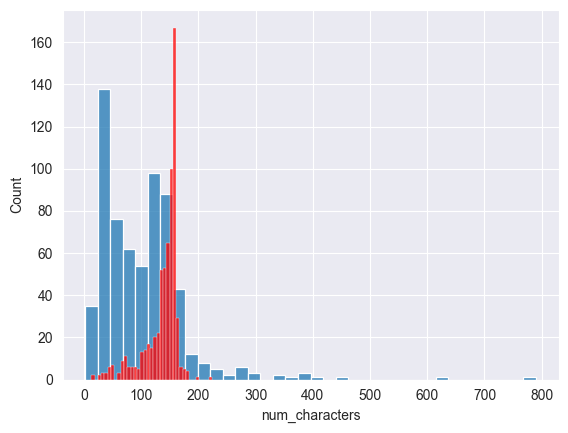

In [272]:
import seaborn as sns
sns.histplot(df[df['target'] == 0]['num_characters'])
sns.histplot(df[df['target']==1]['num_characters'], color='red')


Quindi si può notare che i messaggi spam in media hanno un numero di caratteri abbastanza alto.

Ora vado a stampare lo stesso tipo di grafico, ma per il numero di parole.

<Axes: xlabel='num_words', ylabel='Count'>

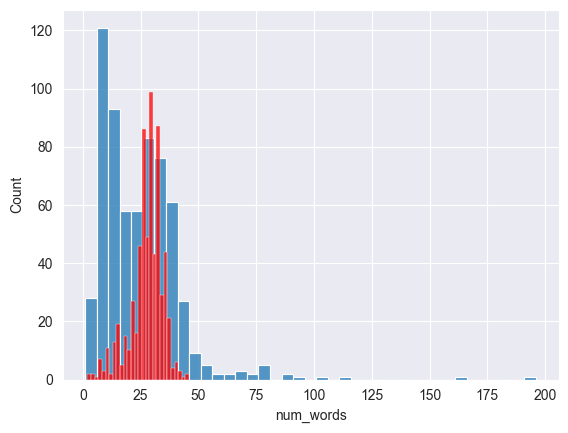

In [273]:
sns.histplot(df[df['target']==0]['num_words'])
sns.histplot(df[df['target']==1]['num_words'], color='red')

Inoltre come si può notare da tale grafico, i messaggi spam hanno in media un numero di parole abbastanza alto. Difatti si verifica, come si può notare dalle colonne rosse, che addirittura in 100 esemplari spam il testo sia di oltre 30 words. Mentre nei messagi legittimi (ham) il numero di words è in determinati casi più basso.

Ora stampo un grafico riassuntivo, un pairplot.
In un pairplot, ciascuna variabile numerica presente nel dataset viene confrontata con tutte le altre variabili numeriche tramite grafici a dispersione, quindi vengono mostrati i punti di dati lungo l'incrocio di tutte le variabili, consentendo di visualizzare e individuare eventuali relazioni o tendenze tra le variabili.

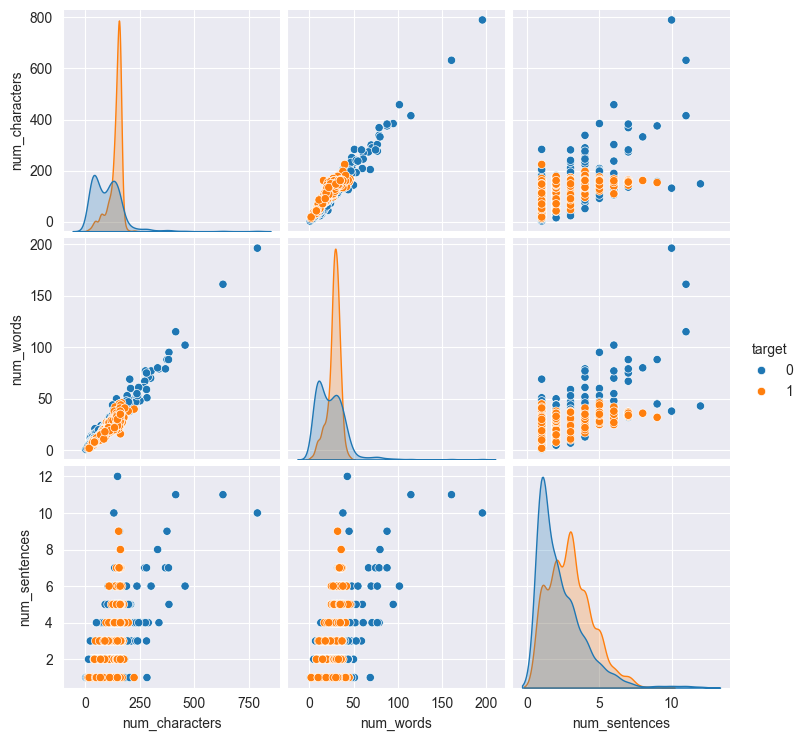

In [274]:
sns.pairplot(df, hue='target')

Emerge dal pairplot:
- sms spam hanno in media un numero di caratteri maggiore dei messaggi ham
- sms spam hanno in media un numero di word maggiore rispetto ai messaggi ham
- il numero di frasi è invece prevalentemente maggiore negli sms ham.

Vado a visualizzare gli stessi dati con la matrice di correlazione, che mi restituisce le correlazioni tra le variabili del dataset, prima di fare ciò devo escludere dal dataframe la colonna text

In [275]:
df_without_text = df.drop(columns=["text"])
df_without_text.corr()

,target,num_characters,num_words,num_sentences
target,1.000000,0.316661,0.125776,0.214139
num_characters,0.316661,1.000000,0.947130,0.563920
num_words,0.125776,0.947130,1.000000,0.601278
num_sentences,0.214139,0.563920,0.601278,1.000000


vado a rappresentare tali valori con una heatmap che utilizza colori per visualizzare i valori dei coefficienti di correlazione tra le diverse coppie di variabili nel dataset, consentendo di individuare facilmente relazioni tra di esse.
All'interno della mappa:
- Le celle più scure o più chiare indicano correlazioni più forti o più deboli, rispettivamente. 
- le variabili che sono fortemente correlate tra loro (valori vicini a 1 o -1) o variabili che hanno una bassa correlazione (valori vicini a 0).

<Axes: >

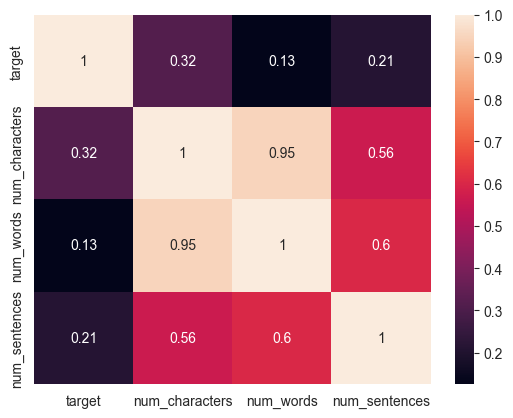

In [276]:
sns.heatmap(df_without_text.corr(), annot=True)

Dalla heatmap emergono svariate considerazioni facilemente spiegabili: 
- forte correlazioni tra numero di parole e numero di caratteri


# Data preparation (Data cleaning)

Rientra nella fase di pulizia dei dati, e vado ad eseguire i seguenti passaggi:
- portare tutto il testo in miniscolo
- tokenizzazione
- rimozione caratteri speciali
- rimozione punteggiatura e stopwords
- stemming (sostituire le parole con la loro radice)

Creo una funzione che esegua tutti questi passi, che prenda in input del testo, e mi restituisca in output del testo preprocessato, ovvero minuscolo, tokenizzato, senza caratteri speciali e stopword, con tutte le words riporatte alla forma base.

In [277]:
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

#stemmer utilizzato per ridurre le parole alla loro forma di base (stemma/radice).
ps = PorterStemmer() 



def transform_text(text):
    text = text.lower() #trasforma tutto in minuscolo per una maggiore coerenza durante l'analisi
    text = nltk.word_tokenize(text) #Utilizza la tokenizzazione per suddividere il testo in una lista di parole (token).
    
    #Rimuove i caratteri non alfanumerici (simboli che non sono né lettere dell'alfabeto né numeri) mantenendo solo le parole alfanumeriche.
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    # Rimuove le stopwords (parole comuni senza un significato specifico) e la punteggiatura.
    #Le stopwords sono parole comuni considerate insignificanti ai fini dell'analisi del testo perché sono molto frequenti in una lingua, ma portano con sé poco significato (come gli articoli, le preposizioni, le congiunzioni ecc. ).
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    #Esegue lo stemming delle parole (riduzione alla forma base/radice utile per ridurre le variazioni delle parole semplificando così l'analisi del testo
    for i in text:
        y.append(ps.stem(i))
    
    #Restituisce il testo pre-elaborato come una stringa di parole separate tra spazi.        
    return " ".join(y)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samuelerusso/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


test funzione su più frasi:

In [278]:
transform_text('"Data scientists use tools like Python, R, and SQL to analyze large datasets, employing machine learning algorithms to extract valuable insights and patterns!"')

'data scientist use tool like python r sql analyz larg dataset employ machin learn algorithm extract valuabl insight pattern'

In [279]:
transform_text('URGENT!! 🚨 Your 100 % FREE PRIZE awaits! Claim NOW by texting "WIN" to 555-1234. Don t miss this EXCLUSIVE offer! 🎁🌟')

'urgent 100 free prize await claim text win miss exclus offer'

Ora procedo a trasformare il testo di tutti gli sms presenti nel dataset, e li inserisco in una nuova colonna.


In [280]:
df['text'].apply(transform_text)

1147                                 ok help ask work tmr
437                                long applebe fuck take
2283                         reach home safe n sound liao
5514                                    oh oki lor go sat
3443                                    ye care caus know
                              ...                        
5537    want explicit sex 30 sec ring 02073162414 cost...
5540    ask 3mobil 0870 chatlin inclu free min india c...
5547    contract mobil 11 mnth latest motorola nokia e...
5566    remind o2 get pound free call credit detail gr...
5567    2nd time tri 2 contact u pound prize 2 claim e...
Name: text, Length: 1293, dtype: object

In [281]:
df['transformed_text'] = df['text'].apply(transform_text)

In [282]:
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
1147,0,Ok... Help me ask if she's working tmr a not?,45,13,1,ok help ask work tmr
437,0,How long does applebees fucking take,36,6,1,long applebe fuck take
2283,0,I reach home safe n sound liao...,33,8,1,reach home safe n sound liao
5514,0,Oh... Okie lor...We go on sat...,33,10,1,oh oki lor go sat
3443,0,Yes but I don't care cause I know its there!,44,12,1,ye care caus know


Ora che ho pulito i dati, vado a plottare alcuni grafici per capire quali sono le words più ricorrenti nelle classi ham/spam, per avere idea di quali saranno le parole che impatteranno la predizione di un sms ham/spam.

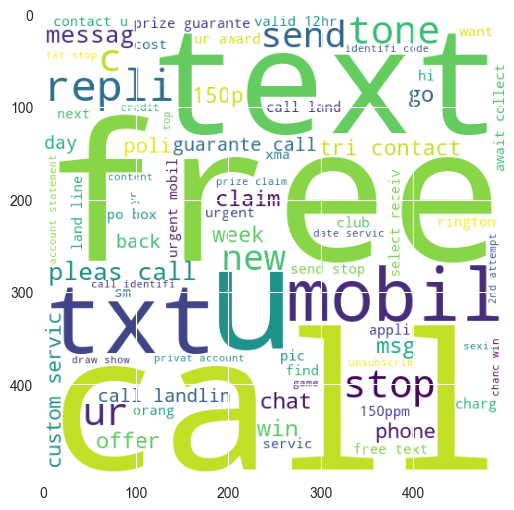

In [283]:
#utilizzo la libreria WordCLoud
from wordcloud import WordCloud

wc= WordCloud(width=500, height=500, min_font_size=10, background_color='white')

spam_words = wc.generate(df[df['target']==1]['transformed_text'].str.cat(sep=" "))

plt.figure(figsize=(15, 6))
plt.imshow(spam_words)

Qui sopra ci sono le parole più diffuse nei testi si sms spam.
Ora vado a ricavare lo stesso grafico per gli sms ham.

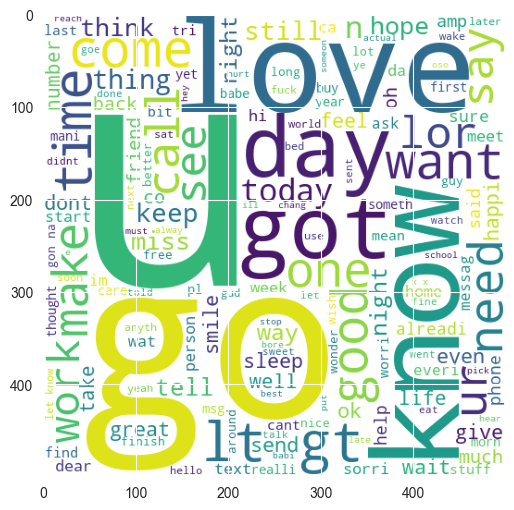

In [284]:
ham_words = wc.generate(df[df['target']==0]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15, 6))
plt.imshow(spam_words)

Quindi da questi due grafici va ad emergere quali sono le parole più diffuse negli sms ham/spam, quindi il classificatore andrà anche a basarsi sulla ricorrenza di tali parole per andare a classificare un sms.


## Data Preparation (Feature scaling)

Da come emerge, le scale fra numero di caratteri, numero di parole e numero di frasi sono diverse... quindi vado a normalizzare i vari valori utilizzando la tecnica più diffusa: min max normalization.

In [285]:
from sklearn.preprocessing import MinMaxScaler

#colonne che voglio normalizzare
features_to_normalize = ['num_characters', 'num_words', 'num_sentences']

#oggetto che permette la normalizzazione
scaler = MinMaxScaler() 

df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])



Stampo un campione per vedere se tutto ha avuto successo.

In [286]:
df.sample(10)

,target,text,num_characters,num_words,num_sentences,transformed_text
1477,0,Why you keeping me away like this,0.039340,0.030769,0.000000,keep away like
550,0,Imagine you finally get to sink into that bath...,0.354061,0.297436,0.181818,imagin final get sink bath put pace mayb even ...
5468,1,URGENT! Last weekend's draw shows that you hav...,0.178934,0.169231,0.363636,urgent last weekend draw show cash spanish hol...
332,1,Call Germany for only 1 pence per minute! Call...,0.159898,0.138462,0.272727,call germani 1 penc per minut call fix line vi...
2766,1,Married local women looking for discreet actio...,0.194162,0.143590,0.181818,marri local women look discreet action 5 real ...
1697,0,Hai priya are you right. What doctor said pa. ...,0.073604,0.066667,0.090909,hai priya right doctor said
629,1,Todays Vodafone numbers ending with 4882 are s...,0.187817,0.133333,0.090909,today vodafon number end 4882 select receiv aw...
3979,1,ringtoneking 84484,0.020305,0.005128,0.000000,ringtonek 84484
836,1,Do you want 750 anytime any network mins 150 t...,0.186548,0.138462,0.000000,want 750 anytim network min 150 text new video...
1462,1,09066362231 URGENT! Your mobile No 07xxxxxxxxx...,0.191624,0.143590,0.272727,09066362231 urgent mobil 07xxxxxxxxx bonu call...


Come si può notare ora tutto è normalizzato

# Data Preparation (Feature Selection)

Si può notare che num_sentences assumeva già prima della feature scaling un valore quasi sempre uguale (1, 2, 3), quindi è una feature a bassa varianza... di conseguenza è una feature poco predittiva quindi procedo ad eliminarla.

In [287]:
df = df.drop('num_sentences', axis=1) #axis=1 vuol dire colonne, axis=0 righe

#stampo un sample per vedere se è tutto ok
df.sample(5)

,target,text,num_characters,num_words,transformed_text
947,0,Hey i booked the kb on sat already... what oth...,0.178934,0.153846,hey book kb sat alreadi lesson go ah keep sat ...
2301,0,"&lt;#&gt; , that's all? Guess that's easy enough",0.058376,0.082051,lt gt guess easi enough
5020,0,:-( sad puppy noise,0.021574,0.025641,sad puppi nois
4381,0,yeah sure thing mate haunt got all my stuff so...,0.177665,0.148718,yeah sure thing mate haunt got stuff sort im g...
2956,0,I would but I'm still cozy. And exhausted from...,0.137056,0.112821,would still cozi exhaust last went school work...


## Modeling 

In [288]:
from sklearn.feature_extraction.text import TfidfVectorizer

#serve per trasformare i testi in una rappresentazione numerica
tfidf = TfidfVectorizer(max_features=3000) #max_features limita il numero di termini da considerare, in questo caso solo i primi 3000 termini più rilevanti

X = tfidf.fit_transform(df['transformed_text']).toarray() #trasformo il testo in tfid 


In [289]:
X.shape #restituisce le dimensioni della matrice X, nel mio caso (numero_di_righe, numero_di_colonne), dove 1293 sono gli sms e 3000 è la lunghezza di rappresentazione di ogni sms in tfid (rappr. numerica) 

(1293, 3000)

In [290]:
#salvo in y i valori di target (ham/spam), ovvero 0 e 1
y = df['target'].values 

Ho bisogno di splittare il mio dataset in dati training e dati di test. Per far ciò uso il train_test_split di Sklearn.

In [291]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=2) #opto per 75% training e 25% test (dato che non ho moltissimi dati)

A questo punto, una volta che i dati sono pronti per essere processati da un algortimo, e ho diviso i miei dati in due insiemi distinti (dati training e dati test), posso procedere a selezionare uno o più algortimi, e quindi a costruire il modello.

# Naive Bayes

In [292]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

Come primo algoritmo ho scelto Naive Bayes, che però è presente con distribuzioni differenti (bernoulli, multinomiale, gaussiana) che si differenziano per la natura dei dati che sono progettati per trattare.
Naive Bayes:
- GaussianNB (Naive Bayes Gaussiano), datto per dati continui e spesso utilizzato quando le feature del dataset sono numeriche.
- MultinomialNB (Naive Bayes Multinomiale), utilizzato per dati discreti, come conteggi di parole e spesso utilizzato per problemi di classificazione di testi, dove le feature sono rappresentazioni di conteggio delle parole o frequenze delle parole
- BernoulliNB (Naive Bayes di Bernoulli), adatto per dati dove sono presento feature booleane, spesso utilizzato in problemi di classificazione con dati binari, come la classificazione di documenti come spam o non-spam.

Quindi emerge che probabilmente la distribuzione gaussiana è quella che meglio si presta nel mio caso, vado quindi ad approfindire eseguendo il train su ognuno dei 3 modelli con gli stessi dati di training e di test.


In [293]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

Naive Bayes MNB (Multinomial)

Accuracy:  0.9290123456790124
Precision:  0.9349112426035503


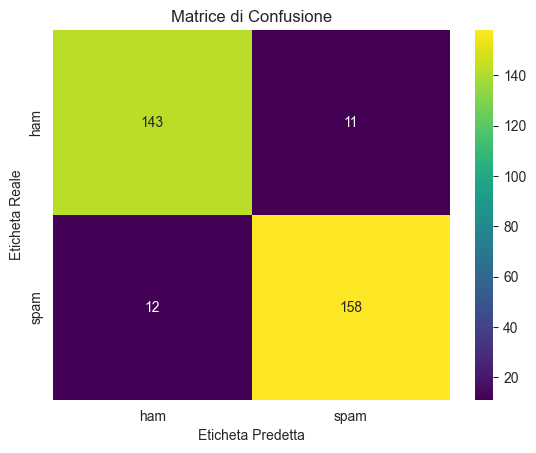

In [294]:
#procedo ad addestrare il modello sui dati di training

mnb.fit(X_train,y_train)

#predizioni 
y_pred = mnb.predict(X_test)
print('Accuracy: ' ,accuracy_score(y_test,y_pred))
print('Precision: ' ,precision_score(y_test,y_pred))

#plot della matrice di confusione
labels = ['ham', 'spam']
confusion_matrix_result = confusion_matrix(y_test,y_pred)
sns.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='viridis', xticklabels=labels, yticklabels=labels)
plt.title('Matrice di Confusione')
plt.xlabel('Eticheta Predetta')
plt.ylabel('Eticheta Reale')
plt.show()

Naive Bayes GNB (Gaussian)

Accuracy:  0.9351851851851852
Precision:  0.9461077844311377


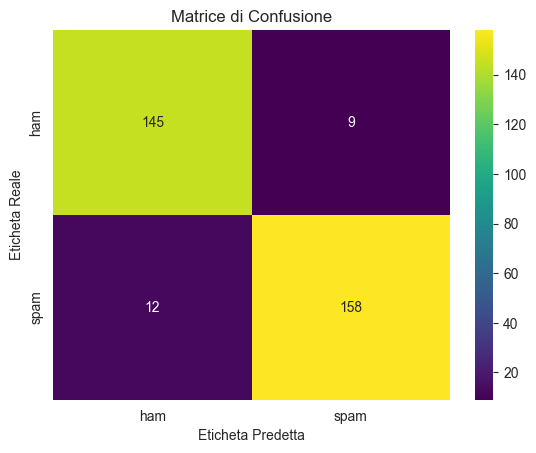

In [295]:
gnb.fit(X_train,y_train) #training 
y_pred1 = gnb.predict(X_test) #testing
print('Accuracy: ' , accuracy_score(y_test,y_pred1))
print('Precision: ' , precision_score(y_test,y_pred1))

#plot della matrice di confusione
labels = ['ham', 'spam']
confusion_matrix_result = confusion_matrix(y_test,y_pred1)
sns.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='viridis', xticklabels=labels, yticklabels=labels)
plt.title('Matrice di Confusione')
plt.xlabel('Eticheta Predetta')
plt.ylabel('Eticheta Reale')
plt.show()


Naive Bayes BNB (Bernoulli)

Accuracy:  0.9506172839506173
Precision:  0.98125


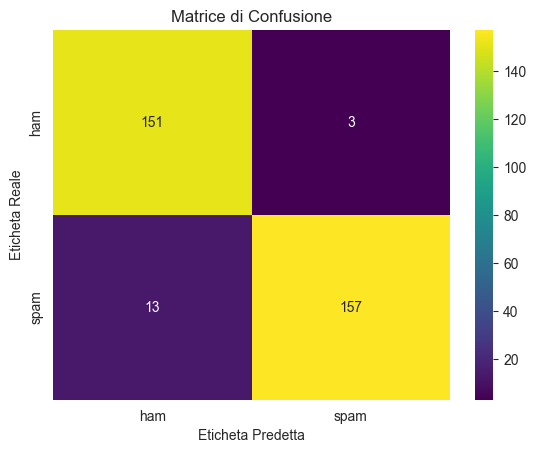

In [296]:
bnb.fit(X_train,y_train) #training modello
y_pred3 = bnb.predict(X_test) #test modello
print('Accuracy: ' ,accuracy_score(y_test,y_pred3))
print('Precision: ' ,precision_score(y_test,y_pred3))

#plot della matrice di confusione
labels = ['ham', 'spam']
confusion_matrix_result = confusion_matrix(y_test,y_pred3)
sns.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='viridis', xticklabels=labels, yticklabels=labels)
plt.title('Matrice di Confusione')
plt.xlabel('Eticheta Predetta')
plt.ylabel('Eticheta Reale')
plt.show()


Quindi da come emerge dai vari test, il naive bayes con tutte le distribuzioni si comporta in maniera molto molto simile, ma i risultati migliori si sono ottenuti con la distribuzione di bernoulli.

Vado ora a provare l'utilizzo di un ulteriore algortimo visto nelle lezioni sulla classificazioni, ovvero gli alberi decisionali

# Alberi decisionali (Decision Tree Classifier)

Gli alberi decisionali sono algoritmi di apprendimento supervisionato utilizzati per la classificazione, l'obiettivo principale è quello di creare un modello che possa prendere decisioni basate su una serie di domande poste sulle feature dei dati.

Funzionamento in breve:
- L'algoritmo inizia selezionando la feature che migliora maggiormente la separazione dei dati in classi omogenee. 
- Il nodo viene diviso in base ai valori possibili della feature selezionata.
- ripeti

In [297]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=8)

Accuracy:  0.8827160493827161
Precision:  0.9230769230769231


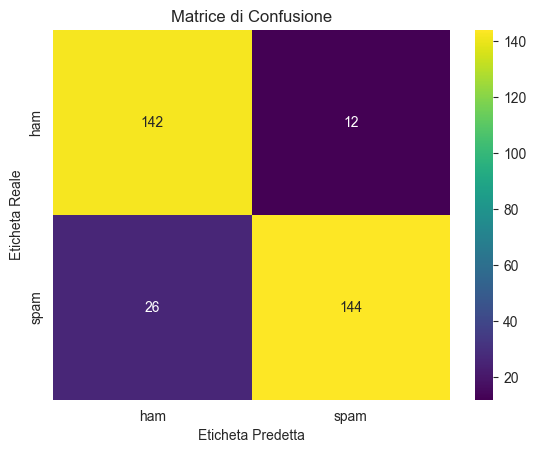

In [298]:
dtc.fit(X_train,y_train)
y_pred = dtc.predict(X_test)
print('Accuracy: ' ,accuracy_score(y_test,y_pred))
print('Precision: ' ,precision_score(y_test,y_pred))

#plot della matrice di confusione
labels = ['ham', 'spam']
confusion_matrix_result = confusion_matrix(y_test,y_pred)
sns.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='viridis', xticklabels=labels, yticklabels=labels)
plt.title('Matrice di Confusione')
plt.xlabel('Eticheta Predetta')
plt.ylabel('Eticheta Reale')
plt.show()